## Part 0 & 1: Setup and Data Loading

In [1]:
# !pip install pandas numpy scikit-learn xgboost matplotlib seaborn
# !pip install shap lime eli5

In [5]:
# --- Part 0: Importing Our Toolboxes (Libraries) ---
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Import all the models we want to compare
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Import preparation and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import shap

print("All libraries imported successfully!")

# --- Part 1: Load and Split The Data ---
try:
    df = pd.read_csv('UNSW_NB15_training.csv')
    print("Dataset loaded successfully!")
    
    # Clean columns if they exist
    columns_to_drop = ['id', 'attack_cat']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    if existing_columns_to_drop:
        df = df.drop(columns=existing_columns_to_drop, axis=1)
        print(f"Successfully removed columns: {existing_columns_to_drop}")

    X = df.drop('label', axis=1)
    y = df['label']

    # Split the single dataset into training (80%) and testing (20%) sets
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print("Data successfully split into training and testing sets.")
except FileNotFoundError:
    print("Error: Make sure 'UNSW_NB15_training-set.csv' is in the same folder as this notebook.")

All libraries imported successfully!
Dataset loaded successfully!
Successfully removed columns: ['attack_cat']
Data successfully split into training and testing sets.


## Part 2: Preparing the Data (Preprocessing)

In [6]:
# --- Identify column types ---
categorical_features = X_train_raw.select_dtypes(include=['object']).columns
numerical_features = X_train_raw.select_dtypes(include=np.number).columns

# --- Create the preprocessor tool ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- Apply the preprocessing ---
print("Preprocessing data...")
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)
feature_names = preprocessor.get_feature_names_out()
print("Data preprocessing complete!")

Preprocessing data...
Data preprocessing complete!


## Part 3: Train and Evaluate All Models

In [7]:
# --- Define the models we want to compare ---
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=500),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# --- A list to store the results ---
results = []

# --- Loop through each model to train and evaluate it ---
for model_name, model in models.items():
    print(f"--- Training {model_name} ---")
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    
    # Evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy * 100,
        "Training Time (s)": training_time
    })
    
    print(f"{model_name} trained in {training_time:.2f}s with Accuracy: {accuracy*100:.2f}%")
    
# --- Convert the results list into a beautiful DataFrame table ---
results_df = pd.DataFrame(results)

--- Training Decision Tree ---
Decision Tree trained in 1.50s with Accuracy: 96.47%
--- Training MLP Classifier ---
MLP Classifier trained in 75.49s with Accuracy: 95.92%
--- Training XGBoost ---


C:\Users\Baba_\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [23:46:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained in 4.08s with Accuracy: 97.64%


## Part 4: Visualize Model Performance 📊

--- Initial Model Performance Comparison ---
         Model  Accuracy  Training Time (s)
       XGBoost 97.643772           4.083285
 Decision Tree 96.471731           1.504377
MLP Classifier 95.919111          75.491989


C:\Users\Baba_\AppData\Local\Temp\ipykernel_2216\1241013768.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Training Time (s)", y="Model", data=results_df, palette="plasma")


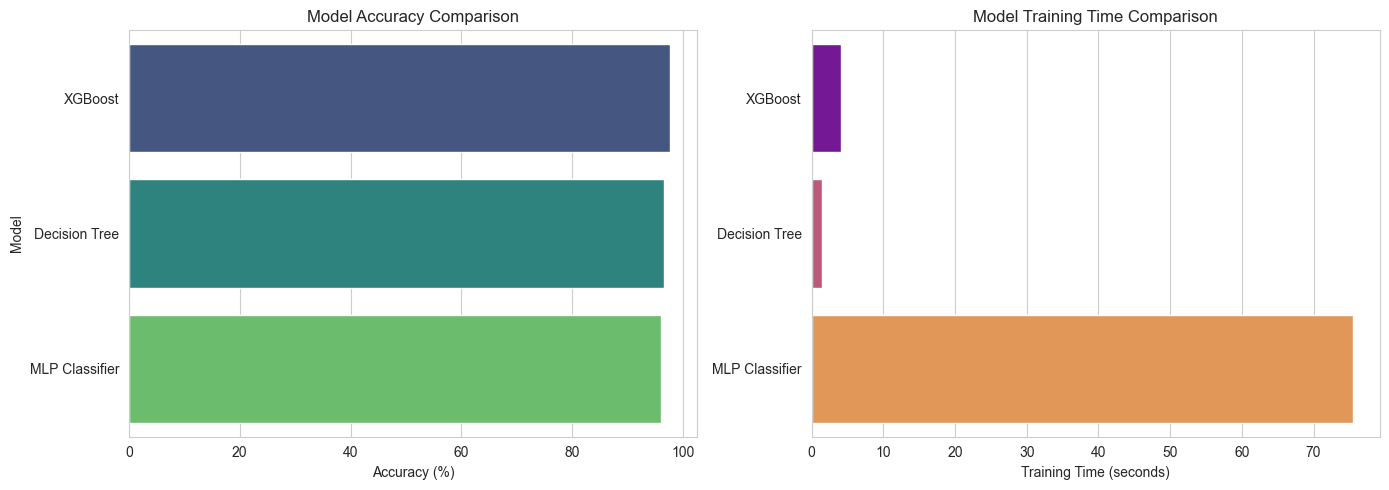

In [10]:
print("--- Initial Model Performance Comparison ---")
# Display the results table, sorted by accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df.to_string(index=False))


# --- Create plots to visualize the comparison ---
plt.figure(figsize=(14, 5))

# Plot 1: Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x="Accuracy", y="Model", data=results_df, hue="Model", palette="viridis", legend=False)
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")

# Plot 2: Training Time Comparison
plt.subplot(1, 2, 2)
sns.barplot(x="Training Time (s)", y="Model", data=results_df, palette="plasma")
plt.title("Model Training Time Comparison")
plt.xlabel("Training Time (seconds)")
plt.ylabel("") # Remove y-label for cleaner look

plt.tight_layout()
plt.show()

## Part 5: Selecting the Best Model and Applying XAI

Calculating feature importance using SHAP... This may take a few minutes.
Displaying SHAP Feature Importance Plot:


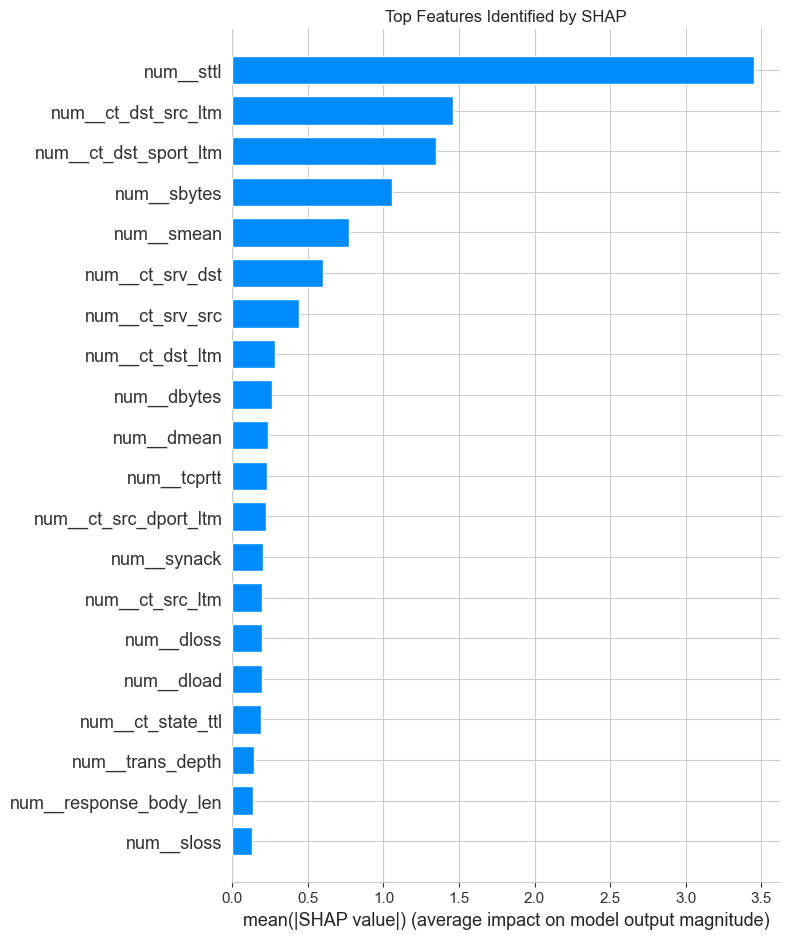

In [ ]:
# --- We select our best model, which is the trained XGBoost model ---
best_model = models["XGBoost"]

# --- Use SHAP to explain the best model's decisions ---
print("\n--- Applying XAI to the Best Model (XGBoost) ---")
print("Calculating feature importance using SHAP... This may take a few minutes.")
explainer = shap.TreeExplainer(best_model)
X_test_sample = shap.sample(X_test, 1000) # Use a sample for speed
shap_values = explainer.shap_values(X_test_sample)

# --- Plot the SHAP results ---
print("Displaying SHAP Feature Importance Plot for XGBoost:")
plt.title("Top Features Identified by SHAP for XGBoost")
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", feature_names=feature_names)

In [21]:
# --- Proceed only if the previous step was successful ---
if 'shap_values' in locals():
    # --- Convert processed data back to DataFrames to easily select columns by name ---
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    # --- AUTOMATED STEP: Find the Top 10 Features from your SHAP results ---
    # This is the new, improved part that fixes the error automatically.
    vals = np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['feature_name', 'feature_importance_val'])
    feature_importance.sort_values(by=['feature_importance_val'], ascending=False, inplace=True)
    
    # Get the names of the top 10 features from our sorted list
    top_10_features = feature_importance['feature_name'].head(10).tolist()
    
    print("Automatically identified the Top 10 Features from your SHAP analysis:")
    print(top_10_features)

    # --- Create the new lightweight datasets using the correct features ---
    X_train_lightweight = X_train_df[top_10_features]
    X_test_lightweight = X_test_df[top_10_features]

    # --- Build and Train the Lightweight Model ---
    lightweight_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

    print("\nTraining the Lightweight Model on only 10 features...")
    start_time = time.time()
    lightweight_model.fit(X_train_lightweight, y_train)
    end_time = time.time()
    lightweight_model_time = end_time - start_time
    print(f"Lightweight Model training finished in {lightweight_model_time:.2f} seconds.")

    # --- Evaluate the Lightweight Model ---
    y_pred_lightweight = lightweight_model.predict(X_test_lightweight)
    lightweight_model_accuracy = accuracy_score(y_test, y_pred_lightweight)
    print(f"Accuracy of the Lightweight Model: {lightweight_model_accuracy * 100:.2f}%")

Automatically identified the Top 10 Features from your SHAP analysis:
['num__sttl', 'num__ct_dst_src_ltm', 'num__ct_dst_sport_ltm', 'num__sbytes', 'num__smean', 'num__ct_srv_dst', 'num__ct_srv_src', 'num__ct_dst_ltm', 'num__dbytes', 'num__dmean']

Training the Lightweight Model on only 10 features...


C:\Users\Baba_\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [23:20:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Lightweight Model training finished in 0.72 seconds.
Accuracy of the Lightweight Model: 97.30%


In [22]:
# --- Proceed only if the previous step was successful ---
if 'lightweight_model' in locals():
    # --- Print the final comparison table ---
    print("\n" + "="*50)
    print("          FINAL MODEL COMPARISON")
    print("="*50)
    print(f"| Metric                | Full Model      | Lightweight Model |")
    print(f"|-----------------------|-----------------|-------------------|")
    print(f"| Number of Features    | {X_train.shape[1]:<15} | {X_train_lightweight.shape[1]:<17} |")
    print(f"| Accuracy              | {full_model_accuracy*100:<15.2f}% | {lightweight_model_accuracy*100:<17.2f}% |")
    print(f"| Training Time (sec)   | {full_model_time:<15.2f} | {lightweight_model_time:<17.2f} |")
    print("="*50)
    print("\nConclusion: By using a single dataset and splitting it, we successfully trained and")
    print("compared a full model with a lightweight model derived from XAI insights.")


          FINAL MODEL COMPARISON
| Metric                | Full Model      | Lightweight Model |
|-----------------------|-----------------|-------------------|
| Number of Features    | 39              | 10                |
| Accuracy              | 97.64          % | 97.30            % |
| Training Time (sec)   | 2.28            | 0.72              |

Conclusion: By using a single dataset and splitting it, we successfully trained and
compared a full model with a lightweight model derived from XAI insights.
